## Facial Pose Estemation

![Face Pose Estimation Using DiLib](dilib.png)

### Load Dataset

In [ ]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

In [2]:
!ls /data

test  test_frames_keypoints.csv  training  training_frames_keypoints.csv  train-test-data.zip


Lab Task is to get validation Loss better than **0.09714**

### Import Libraries

In [3]:
import os
import gc
import cv2
import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.init as I
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader


### Explore Data

In [4]:
trainFramesKeypoints = pd.read_csv('/data/training_frames_keypoints.csv')
trainFramesKeypoints.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


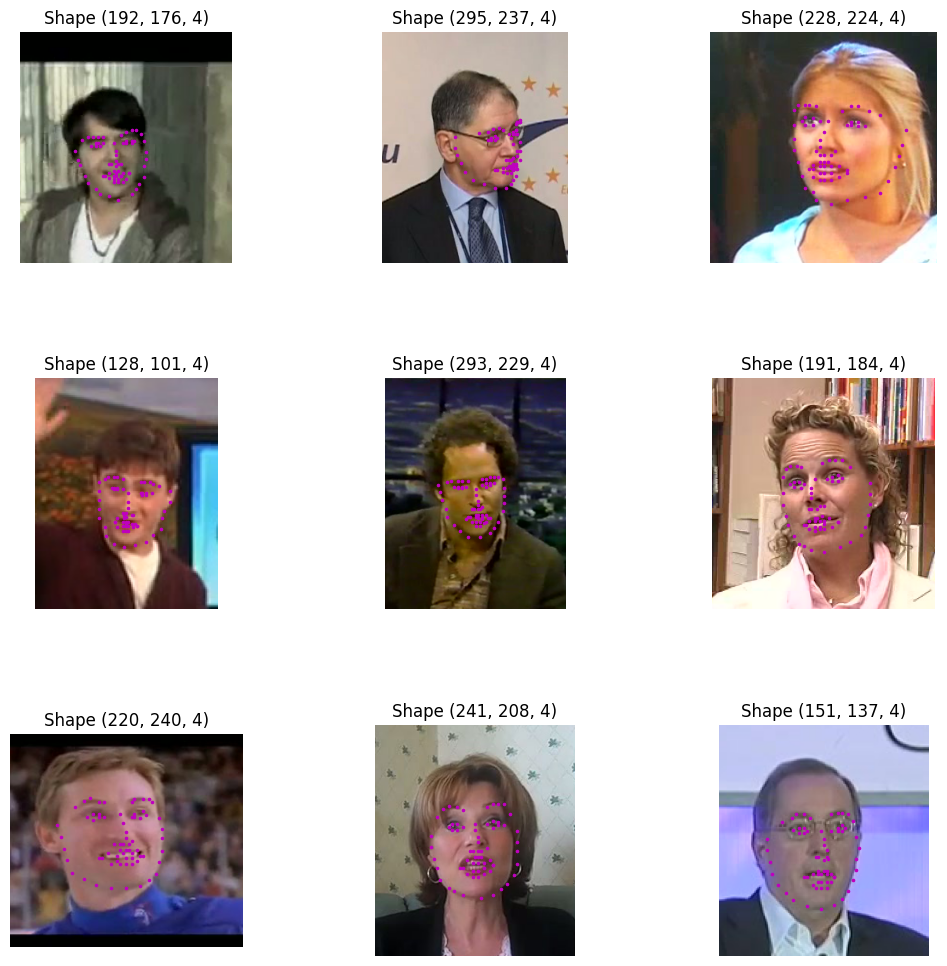

In [6]:
rows = 3
colums = 3
f, ax = plt.subplots(rows, colums, figsize=(12, 12), gridspec_kw={'wspace':0.5, 'hspace':0.5}, squeeze=True)

for r in range(rows):
  for c in range(colums):
    image_ind = r * 6 - c
    image = mpimg.imread(os.path.join('/data/training/',trainFramesKeypoints.iloc[image_ind, 0]))
    keypoint = trainFramesKeypoints.iloc[image_ind, 1:].values
    keypoint = keypoint.astype('float').reshape(-1, 2)
    ax[r,c].axis("off")
    ax[r,c].imshow(image)
    ax[r,c].scatter(keypoint[:, 0], keypoint[:, 1], s=10, marker='.', c='m')
    ax[r,c].set_title(f"Shape {image.shape}")
plt.show()

### Dataset Class

In [7]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csvFile, imageDir, transform=None):

        # directory to save data
        self.csvData = pd.read_csv(csvFile, index_col=0)
        self.imageDir = imageDir
        self.transform = transform

    def __len__(self):
        return len(self.csvData)

    def __getitem__(self, index):
        image_name = os.path.join(self.imageDir,self.csvData.index[index])

        image = mpimg.imread(image_name)
        # if image has an alpha color channel, get rid of it
        if image.shape[2] == 4:
            image = image[:, :, 0:3]

        keypoints = self.csvData.iloc[index, :].values
        keypoints = keypoints.astype('float').reshape(-1, 2)

        data = {'image': image, 'keypoints': keypoints}
        if self.transform:
            data = self.transform(data)

        return data

### Customized Transformation

In [22]:
class Normalize(object):
    """Convert image to grayscale and normalize the color range to [0,1]"""

    def __call__(self, data):
        image, keypoints = data["image"], data["keypoints"]

        imageCopy = np.copy(image)
        keypointsCopy = np.copy(keypoints)

        # convert image to grayscale
        imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        imageCopy = cv2.normalize(imageCopy, imageCopy, 0, 1, cv2.NORM_MINMAX)

        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        keypointsCopy = (keypointsCopy - 100)/50

        return {"image": imageCopy, "keypoints": keypointsCopy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):
        image, keypoints = data["image"], data["keypoints"]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h),interpolation = cv2.INTER_CUBIC)

        # scale the pts, too
        keypoints = keypoints * [new_w / w, new_h / h]

        return {"image": img, "keypoints": keypoints}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        image, keypoints = data["image"], data["keypoints"]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        # crop the image
        image = image[top: top + new_h, left: left + new_w]
        # change keypoints as well
        keypoints = keypoints - [left, top]

        return {"image": image, "keypoints": keypoints}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        image, keypoints = data["image"], data["keypoints"]

        # if image has no grayscale color channel, add one
        if len(image.shape) == 2:
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], -1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {
            "image": torch.from_numpy(image),
            "keypoints": torch.from_numpy(keypoints),
        }
class NormalizeOriginal(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy = cv2.normalize(image_copy, image_copy, 0, 1, cv2.NORM_MINMAX)

        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100) / 50

        return {"image": image_copy, "keypoints": key_pts_copy}

In [23]:
dataTransform =  transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

### DataLoader

In [24]:
train_dataset = FacialKeypointsDataset(csvFile='/data/training_frames_keypoints.csv',imageDir = "/data/training/",transform=dataTransform)
test_dataset = FacialKeypointsDataset(csvFile='/data/test_frames_keypoints.csv',imageDir="/data/test/",transform=dataTransform)
# Create a DataLoader
batch_size = 128
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Function to display an image and its keypoints
def show_keypoints(image, keypoints):
    plt.title(f"Image Shape {image.shape}")
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')

# Iterate over the DataLoader to get a batch of data
for i, batch in enumerate(trainDataLoader):
    images, keypoints = batch["image"], batch["keypoints"]

    # Convert torch tensors to numpy arrays
    images = images.numpy()
    keypoints = keypoints.numpy()

    # If the batch size is greater than 1, select one sample to visualize
    if batch_size > 1:
        rand_idx = np.random.randint(0, batch_size)
        images = images[rand_idx]
        keypoints = keypoints[rand_idx]

    # Reshape the image if it has a single channel
    if images.shape[0] == 1:
        images = images.reshape(images.shape[1], images.shape[2])

    # Denormalize keypoints to original scale
    keypoints = (keypoints * 50) + 100

    # Show the image and keypoints
    show_keypoints(images, keypoints)
    break

plt.show()


### Network

In [31]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining all the layers of this CNN, the only requirements are:
        # 1. This network takes in a square (same width and height), grayscale image as input
        # 2. It ends with a linear layer that represents the keypoints
        # We make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs

        # default conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # default maxpool2d: kernel_size, stride=kernel_size, padding=0

        ...

        self.fc3 = nn.Linear(..., 136)
        # use xavier_uniform_ for the initialization of weights in neural networks
        ...

    def forward(self, x):
        # Defining the feedforward behavior of this model
        # x is the input image and, as an example, here we may choose to include a pool/conv step:

        x = ...

        # flatten
        x = x.view(x.size(0), -1)

        x = ...

        x = self.fc3(x)

        return x

### Setting

In [32]:
num_epochs = 50
model = Network()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data in tqdm(trainDataLoader):
        image, keypoints = data['image'] , data['keypoints']
        image = image.to(device)
        keypoints = keypoints.to(device)
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()

        outputs = model(image)
        loss = criterion(outputs, keypoints)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average training loss for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainDataLoader)}')
    torch.cuda.empty_cache()
    gc.collect()



In [35]:
# Validation loop
model.eval()
with torch.no_grad():
    validation_loss = 0.0
    for data in tqdm(testDataLoader):
        image, keypoints = data['image'] , data['keypoints']
        image = image.to(device)

        keypoints = keypoints.to(device)
        keypoints = keypoints.view(keypoints.size(0), -1)
        outputs = model(image)
        loss = criterion(outputs, keypoints)

        validation_loss += loss.item()

    # Print average validation loss
    print(f'Validation Loss: {validation_loss / len(testDataLoader)}')


# Save the trained model if needed
torch.save(model.state_dict(), 'KeyPointsModel.pth')

Validation Loss: 0.09714141852775374


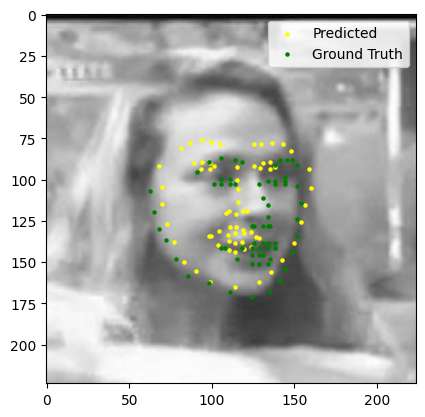

In [36]:
# Function to display an image with predicted and ground truth keypoints
def show_keypoints(image, predicted_keypoints, true_keypoints):
    plt.imshow(image, cmap='gray')
    predicted_keypoints = predicted_keypoints.astype('float').reshape(-1, 2)
    true_keypoints = true_keypoints.astype('float').reshape(-1, 2)

    # Plot predicted keypoints in yellow
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='y', label='Predicted')

    # Plot ground truth keypoints in green
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], s=20, marker='.', c='g', label='True')

    plt.legend()
    plt.pause(0.001)  # pause a bit so that plots are updated

# Set your model to evaluation mode
model.eval()

# Iterate over the DataLoader to get a batch of data
for i, batch in enumerate(testDataLoader):
    images, true_keypoints = batch["image"], batch["keypoints"]

    # Move data to the device
    images = images.to(device)
    true_keypoints = true_keypoints.view(true_keypoints.size(0), -1).to(device)

    # Forward pass to get predicted keypoints
    with torch.no_grad():
        predicted_keypoints = model(images)

    # Convert torch tensors to numpy arrays
    images = images.cpu().numpy()
    predicted_keypoints = predicted_keypoints.cpu().numpy()
    true_keypoints = true_keypoints.cpu().numpy()

    # If the batch size is greater than 1, select one sample to visualize
    if batch_size > 1:
        rand_idx = np.random.randint(0, batch_size)
        images = images[rand_idx]
        predicted_keypoints = predicted_keypoints[rand_idx]
        true_keypoints = true_keypoints[rand_idx]

    # Reshape the image if it has a single channel
    if images.shape[0] == 1:
        images = images.reshape(images.shape[1], images.shape[2])

    # Denormalize keypoints to original scale
    predicted_keypoints = (predicted_keypoints * 50) + 100
    true_keypoints = (true_keypoints * 50) + 100
    # Call show_keypoints
    show_keypoints(images, predicted_keypoints, true_keypoints)


    break

plt.show()
